```
LSTM vs Transformer vs LLaMA vs Diff
```
- 파라미터 수 78만 정도의 작은 모델 & without GQA
- 작은 배치 사이즈

In [1]:
## Importing Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 128
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 2048
EPOCHS = 30
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('./input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([2048, 64])
Target shape: torch.Size([2048, 64])
Sample 1: ------------------------------
Input sequence : CLARENCE:What? what?GLOUCESTER:The Tower, the Tower.QUEEN 
Target sequence: LARENCE:What? what?GLOUCESTER:The Tower, the Tower.QUEEN M

Sample 2: ------------------------------
Input sequence : hou not advised, he took some careTo get her cunning schoolmast
Target sequence: ou not advised, he took some careTo get her cunning schoolmaste

Sample 3: ------------------------------
Input sequence : HAN:All:Ghost of HASTINGS:Ghosts of young Princes:Ghost 
Target sequence: AN:All:Ghost of HASTINGS:Ghosts of young Princes:Ghost o



## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Model 1: GRU Decoder

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.1):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        output, hidden = self.gru(embed, hidden)
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = F.gelu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden

In [19]:
### Model Initialization
gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE)

In [20]:
from torchinfo import summary

summary(gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [2048, 64, 65]            --
├─Embedding: 1-1                         [2048, 64, 128]           8,320
├─GRU: 1-2                               [2048, 64, 256]           691,200
├─Dropout: 1-3                           [2048, 64, 256]           --
├─LayerNorm: 1-4                         [2048, 64, 256]           512
├─Linear: 1-5                            [2048, 64, 256]           65,792
├─Linear: 1-6                            [2048, 64, 65]            16,705
Total params: 782,529
Trainable params: 782,529
Non-trainable params: 0
Total mult-adds (G): 90.78
Input size (MB): 1.05
Forward/backward pass size (MB): 1007.68
Params size (MB): 3.13
Estimated Total Size (MB): 1011.86

In [21]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(gru, train_loader, val_loader, criterion, optimizer, device, EPOCHS)


Epoch 1/30, Train Loss: 1.9118, Val Loss: 1.9889, Epoch Time: 26.72s Average Vram Usage: 53.47MB


Epoch 2/30, Train Loss: 1.6485, Val Loss: 1.8137, Epoch Time: 27.15s Average Vram Usage: 53.47MB


Epoch 3/30, Train Loss: 1.5410, Val Loss: 1.7562, Epoch Time: 26.92s Average Vram Usage: 53.47MB


Epoch 4/30, Train Loss: 1.4738, Val Loss: 1.7356, Epoch Time: 24.01s Average Vram Usage: 53.47MB


Epoch 5/30, Train Loss: 1.4346, Val Loss: 1.7336, Epoch Time: 14.37s Average Vram Usage: 53.47MB


Epoch 6/30, Train Loss: 1.4021, Val Loss: 1.7290, Epoch Time: 14.62s Average Vram Usage: 53.47MB


Epoch 7/30, Train Loss: 1.3548, Val Loss: 1.7233, Epoch Time: 14.47s Average Vram Usage: 53.47MB


Epoch 8/30, Train Loss: 1.3320, Val Loss: 1.7317, Epoch Time: 17.79s Average Vram Usage: 53.47MB


Epoch 9/30, Train Loss: 1.3395, Val Loss: 1.7377, Epoch Time: 14.90s Average Vram Usage: 53.47MB


Epoch 10/30, Train Loss: 1.3050, Val Loss: 1.7519, Epoch Time: 14.60s Average Vram Usage: 53.47MB


Epoch 11/30, Train Loss: 1.3016, Val Loss: 1.7577, Epoch Time: 24.02s Average Vram Usage: 53.47MB


Epoch 12/30, Train Loss: 1.2857, Val Loss: 1.7696, Epoch Time: 27.53s Average Vram Usage: 53.47MB


Epoch 13/30, Train Loss: 1.2547, Val Loss: 1.7762, Epoch Time: 27.71s Average Vram Usage: 53.47MB


Epoch 14/30, Train Loss: 1.2472, Val Loss: 1.7899, Epoch Time: 27.71s Average Vram Usage: 53.47MB


Epoch 15/30, Train Loss: 1.2298, Val Loss: 1.7868, Epoch Time: 26.29s Average Vram Usage: 53.47MB


Epoch 16/30, Train Loss: 1.2302, Val Loss: 1.8135, Epoch Time: 26.93s Average Vram Usage: 53.47MB


Epoch 17/30, Train Loss: 1.2148, Val Loss: 1.8173, Epoch Time: 27.73s Average Vram Usage: 53.47MB


Epoch 18/30, Train Loss: 1.1933, Val Loss: 1.8356, Epoch Time: 27.40s Average Vram Usage: 53.47MB


Epoch 19/30, Train Loss: 1.1854, Val Loss: 1.8344, Epoch Time: 27.51s Average Vram Usage: 53.47MB


Epoch 20/30, Train Loss: 1.1791, Val Loss: 1.8501, Epoch Time: 25.46s Average Vram Usage: 53.47MB


Epoch 21/30, Train Loss: 1.1630, Val Loss: 1.8574, Epoch Time: 27.56s Average Vram Usage: 53.47MB


Epoch 22/30, Train Loss: 1.1661, Val Loss: 1.8722, Epoch Time: 27.47s Average Vram Usage: 53.47MB


Epoch 23/30, Train Loss: 1.1507, Val Loss: 1.8757, Epoch Time: 27.66s Average Vram Usage: 53.47MB


Epoch 24/30, Train Loss: 1.1327, Val Loss: 1.8948, Epoch Time: 27.59s Average Vram Usage: 53.47MB


Epoch 25/30, Train Loss: 1.1386, Val Loss: 1.9082, Epoch Time: 24.78s Average Vram Usage: 53.47MB


Epoch 26/30, Train Loss: 1.1372, Val Loss: 1.9117, Epoch Time: 27.57s Average Vram Usage: 53.47MB


Epoch 27/30, Train Loss: 1.1177, Val Loss: 1.9168, Epoch Time: 27.99s Average Vram Usage: 53.47MB


Epoch 28/30, Train Loss: 1.1151, Val Loss: 1.9229, Epoch Time: 27.83s Average Vram Usage: 53.47MB


Epoch 29/30, Train Loss: 1.1003, Val Loss: 1.9449, Epoch Time: 27.95s Average Vram Usage: 53.47MB


Epoch 30/30, Train Loss: 1.1110, Val Loss: 1.9500, Epoch Time: 25.13s Average Vram Usage: 53.47MB


In [22]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
answer_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0]])
num = 0
while len(answer_text) == len(generated_text):
    num += 1
    answer_text += ''.join([idx_to_char[idx.item()] for idx in val_sample[num]])[-1]    
                      
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)
print(answer_text)
print()

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, good counself, my liege.
Is not your desilence news: I do fear me;
My state is pleasant'stane.

DUKE OF SURREY:
O blessed land is nothing but this hand:
And yet, madam, so you must.

SICINIUS:
Take my general.

QUEEN MARGARET:
Who prays beg born to thee the cap off hers:
These arms and teeth to dram I am not touch'd,
But never but proclaim'd up doth good
Before a man indeed will wather to him that,
Our mother and my conjectsing my passage,
And as we do beg than blows, when I must not
Blush wi


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro



In [23]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('GRU', train_losses_df, val_losses_df)

In [24]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro

Model Output (logits for next character prediction):
torch.Size([1, 64, 65])
tensor([  3.5157,  -7.7264,  -6.7513, -14.0346,  -6.8422,  -0.4294,  -8.0916,
         -7.6485,  -7.8453,  -2.7988], device='cuda:0')

Predicted next character:
w


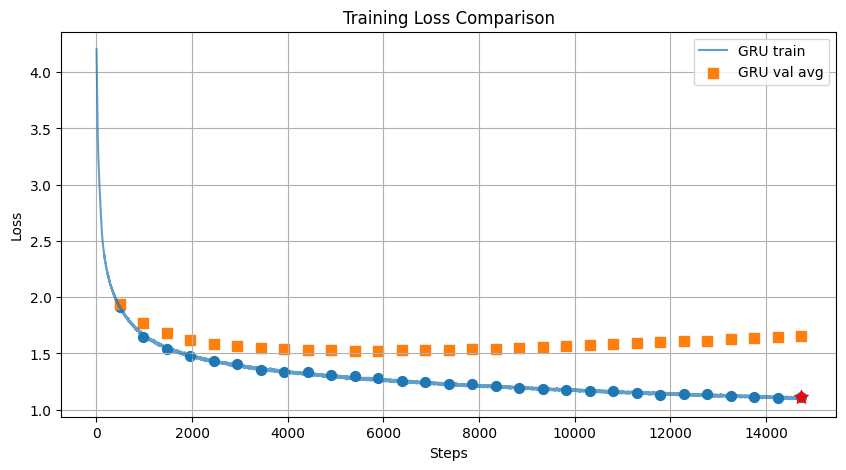

In [25]:
plot_loss_comparisons()

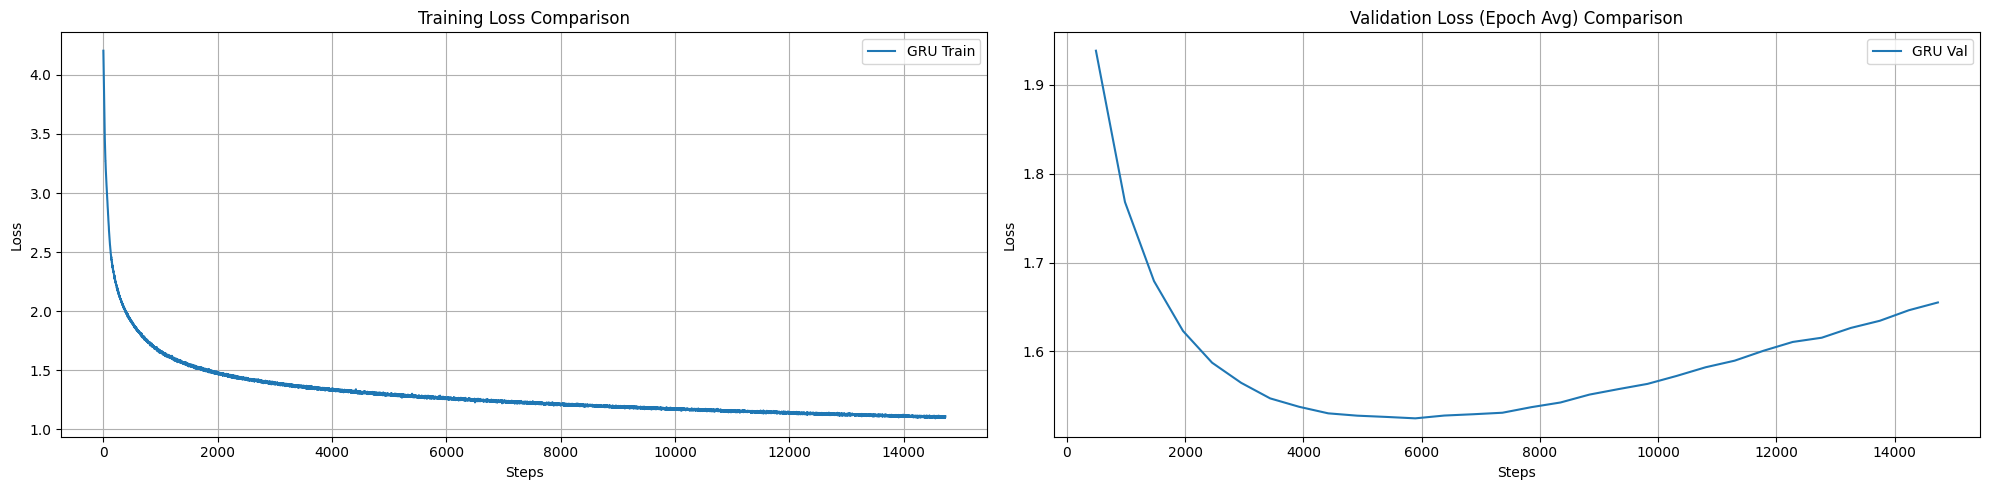

In [26]:
plot_separate_train_val(loss_comparison_dict)

## Model 2: GPT-2(2019)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(dim, ffn_dim)
        self.fc2 = nn.Linear(ffn_dim, dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, ffn_dim, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.ln2 = nn.LayerNorm(dim)
        self.ffn = FeedForward(dim, ffn_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None, return_attn: bool = False):
        # Self-attention with residual connection
        x_norm = self.ln1(x)
        attn_out, attn_weights = self.attn(x_norm, x_norm, x_norm, attn_mask=mask)
        x = x + self.dropout(attn_out)
        # Feed-forward network with residual connection
        x = x + self.dropout(self.ffn(self.ln2(x)))
        if return_attn:
            return x, attn_weights
        return x

class ClassicTransformer(nn.Module):
    def __init__(self, vocab_size, max_seq_len, dim, num_layers, num_heads, ffn_dim, dropout):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, dim)
        self.pos_embedding = nn.Embedding(max_seq_len, dim)
        self.layers = nn.ModuleList([
            TransformerBlock(dim, num_heads, ffn_dim, dropout) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(dim)
        self.output = nn.Linear(dim, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.max_seq_len = max_seq_len
        
    def forward(self, x: torch.Tensor, return_attn: bool = False):
        # x: [B, L]
        B, L = x.shape
        pos_ids = torch.arange(0, L, device=x.device).unsqueeze(0).expand(B, L)
        # Sum token and positional embeddings
        h = self.token_embedding(x) + self.pos_embedding(pos_ids)
        h = self.dropout(h)
        
        # Causal mask (upper triangular with -inf)
        if L > 1:
            mask = torch.triu(torch.full((L, L), float('-inf'), device=x.device), diagonal=1)
        else:
            mask = None
        
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, mask)
            
        h = self.ln_f(h)
        logits = self.output(h)
        if return_attn:
            return logits, attn_maps
        return logits, None


In [28]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [29]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    print("-"*50)
    print(answer_text)
    print("-"*50)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [30]:
# Hyperparameters for Transformer
NUM_LAYERS = 4
NUM_HEADS = 4
FFN_DIM = 480
DROPOUT = 0.1

In [31]:
classic = ClassicTransformer(vocab_size, SEQUENCE_LENGTH, EMBEDDING_DIM, NUM_LAYERS, NUM_HEADS, FFN_DIM, DROPOUT).to(device)
classic

ClassicTransformer(
  (token_embedding): Embedding(65, 128)
  (pos_embedding): Embedding(64, 128)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (fc1): Linear(in_features=128, out_features=480, bias=True)
        (fc2): Linear(in_features=480, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=128, out_features=65, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [32]:
from torchinfo import summary

# Describe the model
summary(classic.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
ClassicTransformer                       [2048, 64, 65]            --
├─Embedding: 1-1                         [2048, 64, 128]           8,320
├─Embedding: 1-2                         [2048, 64, 128]           8,192
├─Dropout: 1-3                           [2048, 64, 128]           --
├─ModuleList: 1-4                        --                        --
│    └─TransformerBlock: 2-1             [2048, 64, 128]           --
│    │    └─LayerNorm: 3-1               [2048, 64, 128]           256
│    │    └─MultiheadAttention: 3-2      [2048, 64, 128]           66,048
│    │    └─Dropout: 3-3                 [2048, 64, 128]           --
│    │    └─LayerNorm: 3-4               [2048, 64, 128]           256
│    │    └─FeedForward: 3-5             [2048, 64, 128]           123,488
│    │    └─Dropout: 3-6                 [2048, 64, 128]           --
│    └─TransformerBlock: 2-2             [2048, 64, 128]           -

Epoch 1/30, Train Loss: 2.4512, Val Loss: 2.4901, Epoch Time: 65.92s Average Vram Usage: 63.48MB


Epoch 2/30, Train Loss: 2.1342, Val Loss: 2.1678, Epoch Time: 62.50s Average Vram Usage: 63.48MB


Epoch 3/30, Train Loss: 1.9498, Val Loss: 2.0083, Epoch Time: 66.52s Average Vram Usage: 63.48MB


Epoch 4/30, Train Loss: 1.8557, Val Loss: 1.9115, Epoch Time: 64.36s Average Vram Usage: 63.48MB


Epoch 5/30, Train Loss: 1.7405, Val Loss: 1.8553, Epoch Time: 65.04s Average Vram Usage: 63.48MB


Epoch 6/30, Train Loss: 1.6850, Val Loss: 1.8198, Epoch Time: 65.02s Average Vram Usage: 63.48MB


Epoch 7/30, Train Loss: 1.6227, Val Loss: 1.7871, Epoch Time: 41.22s Average Vram Usage: 63.48MB


Epoch 8/30, Train Loss: 1.6005, Val Loss: 1.7701, Epoch Time: 52.43s Average Vram Usage: 63.48MB


Epoch 9/30, Train Loss: 1.5588, Val Loss: 1.7479, Epoch Time: 63.95s Average Vram Usage: 63.48MB


Epoch 10/30, Train Loss: 1.5600, Val Loss: 1.7417, Epoch Time: 61.66s Average Vram Usage: 63.48MB


Epoch 11/30, Train Loss: 1.5307, Val Loss: 1.7287, Epoch Time: 61.62s Average Vram Usage: 63.48MB


Epoch 12/30, Train Loss: 1.5099, Val Loss: 1.7209, Epoch Time: 64.17s Average Vram Usage: 63.48MB


Epoch 13/30, Train Loss: 1.4942, Val Loss: 1.7088, Epoch Time: 60.74s Average Vram Usage: 63.48MB


Epoch 14/30, Train Loss: 1.4711, Val Loss: 1.7007, Epoch Time: 63.62s Average Vram Usage: 63.48MB


Epoch 15/30, Train Loss: 1.4437, Val Loss: 1.6925, Epoch Time: 60.34s Average Vram Usage: 63.48MB


Epoch 16/30, Train Loss: 1.4488, Val Loss: 1.6824, Epoch Time: 63.85s Average Vram Usage: 63.48MB


Epoch 17/30, Train Loss: 1.4369, Val Loss: 1.6809, Epoch Time: 61.08s Average Vram Usage: 63.48MB


Epoch 18/30, Train Loss: 1.4434, Val Loss: 1.6762, Epoch Time: 60.92s Average Vram Usage: 63.48MB


Epoch 19/30, Train Loss: 1.4510, Val Loss: 1.6724, Epoch Time: 63.88s Average Vram Usage: 63.48MB


Epoch 20/30, Train Loss: 1.4241, Val Loss: 1.6678, Epoch Time: 59.78s Average Vram Usage: 63.48MB


Epoch 21/30, Train Loss: 1.4081, Val Loss: 1.6604, Epoch Time: 63.84s Average Vram Usage: 63.48MB


Epoch 22/30, Train Loss: 1.4087, Val Loss: 1.6567, Epoch Time: 59.46s Average Vram Usage: 63.48MB


Epoch 23/30, Train Loss: 1.3894, Val Loss: 1.6615, Epoch Time: 63.58s Average Vram Usage: 63.48MB


Epoch 24/30, Train Loss: 1.3768, Val Loss: 1.6571, Epoch Time: 58.88s Average Vram Usage: 63.48MB


Epoch 25/30, Train Loss: 1.3849, Val Loss: 1.6518, Epoch Time: 62.21s Average Vram Usage: 63.48MB


Epoch 26/30, Train Loss: 1.4022, Val Loss: 1.6540, Epoch Time: 61.19s Average Vram Usage: 63.48MB


Epoch 27/30, Train Loss: 1.3773, Val Loss: 1.6578, Epoch Time: 60.07s Average Vram Usage: 63.48MB


Epoch 28/30, Train Loss: 1.3743, Val Loss: 1.6548, Epoch Time: 63.62s Average Vram Usage: 63.48MB


Epoch 29/30, Train Loss: 1.3578, Val Loss: 1.6508, Epoch Time: 58.58s Average Vram Usage: 63.48MB


Epoch 30/30, Train Loss: 1.3585, Val Loss: 1.6533, Epoch Time: 63.99s Average Vram Usage: 63.48MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow neither!

ANGELO:
The same of Gloucester.

COMINIUS:
I do go?

HENRY BOLINGBROKE:
Go expity!
Thus hence with shall for the battle stander straight's,
And Thomas once fearful main with thy father's simple,
We making of half ran that he know'd companion?

MENENIUS:
Die, how now
He strikes treache is hand; then see 'tis.
If thou been so conceivers much, as I like
have way farries, the king of your noble: and but I
conduction, and men by him to thine ears. Where
Once But come, for Lord Bohemia, an
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro
--------------------------------------------------


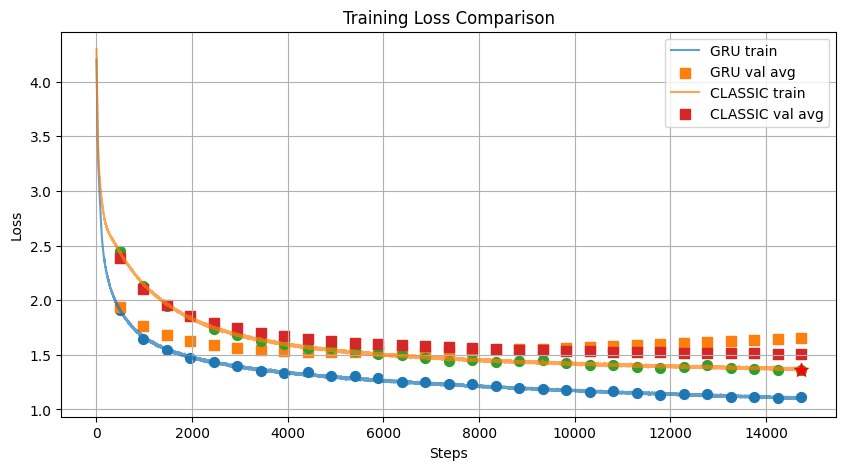

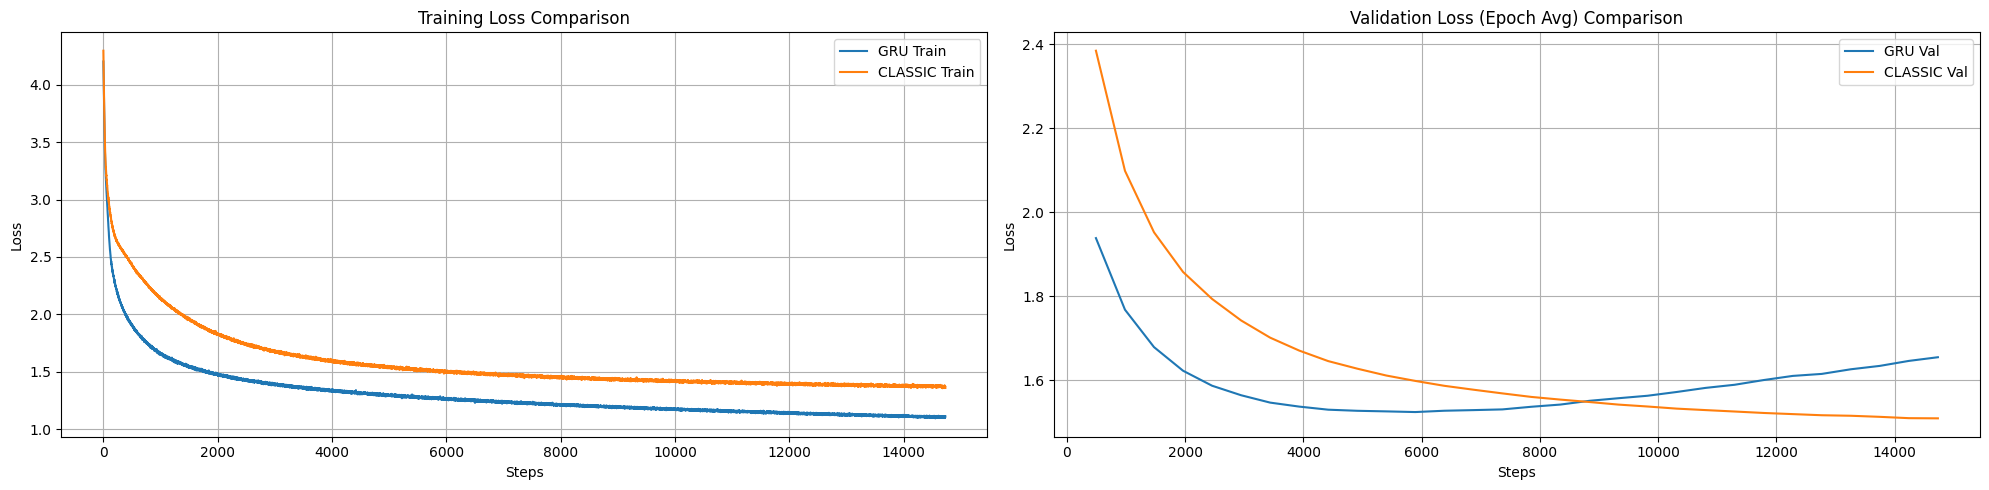

In [33]:
train_and_test("CLASSIC", classic, start_text)

## Model 3: Modern Transformer(LLaMA - 2023)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    # FFN_DIM = HIDDEN_DIM
    FFN_DIM = 320
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        self.norm = RMSNorm(self.head_dim)

    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos
        
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # Apply rotary embeddings
        xq = apply_rotary_emb(xq)
        xk = apply_rotary_emb(xk)
        
        # GQA: Adjust dimensions for attention computation
        xq = xq.transpose(1, 2)   # [B, n_heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]

        # Compute scaled dot-product attention manually to capture attention weights
        scores = torch.matmul(xq, xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, L, L]
        scores = torch.nan_to_num(scores)
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
            
        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        attn_output = torch.matmul(attn_weights, xv)  # [B, n_heads, L, head_dim]
        attn_output = self.norm(attn_output)
        
        # Reshape attention output and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, -1)
        output = self.wo(attn_output)  # [B, L, D]
        if return_attn:
            return output, attn_weights
        else:
            return output

class TransformerBlock(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.attention = SelfAttention(
            args.NUM_HEADS, 
            args.NUM_KV_HEADS, 
            args.NUM_KV_HEAD_REP, 
            args.DIM, 
            args.DROPOUT, 
            args.MAX_BATCH_SIZE, 
            args.MAX_SEQ_LEN, 
            args.DEVICE
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attention_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class LlamaTransformer(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE
        
    def forward(self, x: torch.Tensor, start_pos=0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, D]
        
        mask = None
        if L > 1:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(x),
                1 + start_pos,
            )
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [35]:
PARAMS = ModelArgs()
llama = LlamaTransformer(PARAMS).to(device)
llama

LlamaTransformer(
  (tok_embeddings): Embedding(65, 128)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=128, out_features=128, bias=False)
        (wk): Linear(in_features=128, out_features=128, bias=False)
        (wv): Linear(in_features=128, out_features=128, bias=False)
        (wo): Linear(in_features=128, out_features=128, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=128, out_features=320, bias=False)
        (w2): Linear(in_features=320, out_features=128, bias=False)
        (w3): Linear(in_features=128, out_features=320, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=128, out_features=65, bias=False)
)

In [36]:
from torchinfo import summary

# Describe the model
summary(llama.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LlamaTransformer                         [2048, 64, 65]            --
├─Embedding: 1-1                         [2048, 64, 128]           8,320
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [2048, 64, 128]           --
│    │    └─RMSNorm: 3-1                 [2048, 64, 128]           128
│    │    └─SelfAttention: 3-2           [2048, 64, 128]           65,568
│    │    └─Dropout: 3-3                 [2048, 64, 128]           --
│    │    └─RMSNorm: 3-4                 [2048, 64, 128]           128
│    │    └─FeedForward: 3-5             [2048, 64, 128]           122,880
│    │    └─Dropout: 3-6                 [2048, 64, 128]           --
│    └─TransformerBlock: 2-2             [2048, 64, 128]           --
│    │    └─RMSNorm: 3-7                 [2048, 64, 128]           128
│    │    └─SelfAttention: 3-8           [2048, 64, 128]           65,

Epoch 1/30, Train Loss: 2.0465, Val Loss: 2.0693, Epoch Time: 81.08s Average Vram Usage: 85.48MB


Epoch 2/30, Train Loss: 1.7436, Val Loss: 1.8686, Epoch Time: 80.21s Average Vram Usage: 85.48MB


Epoch 3/30, Train Loss: 1.6489, Val Loss: 1.8033, Epoch Time: 80.06s Average Vram Usage: 85.48MB


Epoch 4/30, Train Loss: 1.5528, Val Loss: 1.7725, Epoch Time: 86.62s Average Vram Usage: 85.48MB


Epoch 5/30, Train Loss: 1.5491, Val Loss: 1.7512, Epoch Time: 79.98s Average Vram Usage: 85.48MB


Epoch 6/30, Train Loss: 1.4750, Val Loss: 1.7403, Epoch Time: 79.09s Average Vram Usage: 85.48MB


Epoch 7/30, Train Loss: 1.4603, Val Loss: 1.7348, Epoch Time: 78.54s Average Vram Usage: 85.48MB


Epoch 8/30, Train Loss: 1.4360, Val Loss: 1.7207, Epoch Time: 84.18s Average Vram Usage: 85.48MB


Epoch 9/30, Train Loss: 1.4253, Val Loss: 1.7073, Epoch Time: 82.50s Average Vram Usage: 85.48MB


Epoch 10/30, Train Loss: 1.4212, Val Loss: 1.7041, Epoch Time: 76.84s Average Vram Usage: 85.48MB


Epoch 11/30, Train Loss: 1.4059, Val Loss: 1.6986, Epoch Time: 78.07s Average Vram Usage: 85.48MB


Epoch 12/30, Train Loss: 1.3646, Val Loss: 1.6979, Epoch Time: 83.84s Average Vram Usage: 85.48MB


Epoch 13/30, Train Loss: 1.3727, Val Loss: 1.6893, Epoch Time: 81.62s Average Vram Usage: 85.48MB


Epoch 14/30, Train Loss: 1.3596, Val Loss: 1.6859, Epoch Time: 77.59s Average Vram Usage: 85.48MB


Epoch 15/30, Train Loss: 1.3537, Val Loss: 1.6841, Epoch Time: 77.21s Average Vram Usage: 85.48MB


Epoch 16/30, Train Loss: 1.3464, Val Loss: 1.6823, Epoch Time: 84.55s Average Vram Usage: 85.48MB


Epoch 17/30, Train Loss: 1.3559, Val Loss: 1.6837, Epoch Time: 80.64s Average Vram Usage: 85.48MB


Epoch 18/30, Train Loss: 1.3241, Val Loss: 1.6900, Epoch Time: 77.34s Average Vram Usage: 85.48MB


Epoch 19/30, Train Loss: 1.3384, Val Loss: 1.6837, Epoch Time: 76.78s Average Vram Usage: 85.48MB


Epoch 20/30, Train Loss: 1.3408, Val Loss: 1.6753, Epoch Time: 86.08s Average Vram Usage: 85.48MB


Epoch 21/30, Train Loss: 1.3281, Val Loss: 1.6792, Epoch Time: 77.61s Average Vram Usage: 85.48MB


Epoch 22/30, Train Loss: 1.3117, Val Loss: 1.6821, Epoch Time: 76.34s Average Vram Usage: 85.48MB


Epoch 23/30, Train Loss: 1.3454, Val Loss: 1.6760, Epoch Time: 77.28s Average Vram Usage: 85.48MB


Epoch 24/30, Train Loss: 1.2999, Val Loss: 1.6788, Epoch Time: 86.10s Average Vram Usage: 85.48MB


Epoch 25/30, Train Loss: 1.3259, Val Loss: 1.6800, Epoch Time: 75.44s Average Vram Usage: 85.48MB


Epoch 26/30, Train Loss: 1.3067, Val Loss: 1.6771, Epoch Time: 74.62s Average Vram Usage: 85.48MB


Epoch 27/30, Train Loss: 1.2814, Val Loss: 1.6764, Epoch Time: 82.23s Average Vram Usage: 85.48MB


Epoch 28/30, Train Loss: 1.3177, Val Loss: 1.6830, Epoch Time: 80.93s Average Vram Usage: 85.48MB


Epoch 29/30, Train Loss: 1.3051, Val Loss: 1.6785, Epoch Time: 74.56s Average Vram Usage: 85.48MB


Epoch 30/30, Train Loss: 1.2898, Val Loss: 1.6825, Epoch Time: 75.81s Average Vram Usage: 85.48MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow in step; he'd any thing
Shall we still affect things; go with father's honour;
All this is return for the pireon of death?
And where! our ready is so harlot! I'll say he were;
My suit I orday and execution, all this innocent.

GRUMIO:
Pray you, I have a most profit
His daughter did I follow your words at water
And so much other Clarence, look yourself.

GLOUCESTER:
I, as I love thee breathe you, and all the part is this rather mine.

LUCENTIO:
How, a man, my lord and mine arms again,
And harsh
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro
--------------------------------------------------


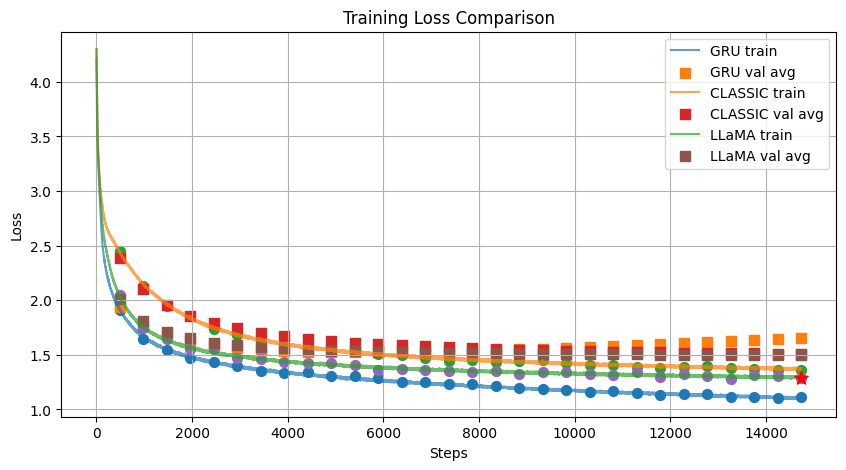

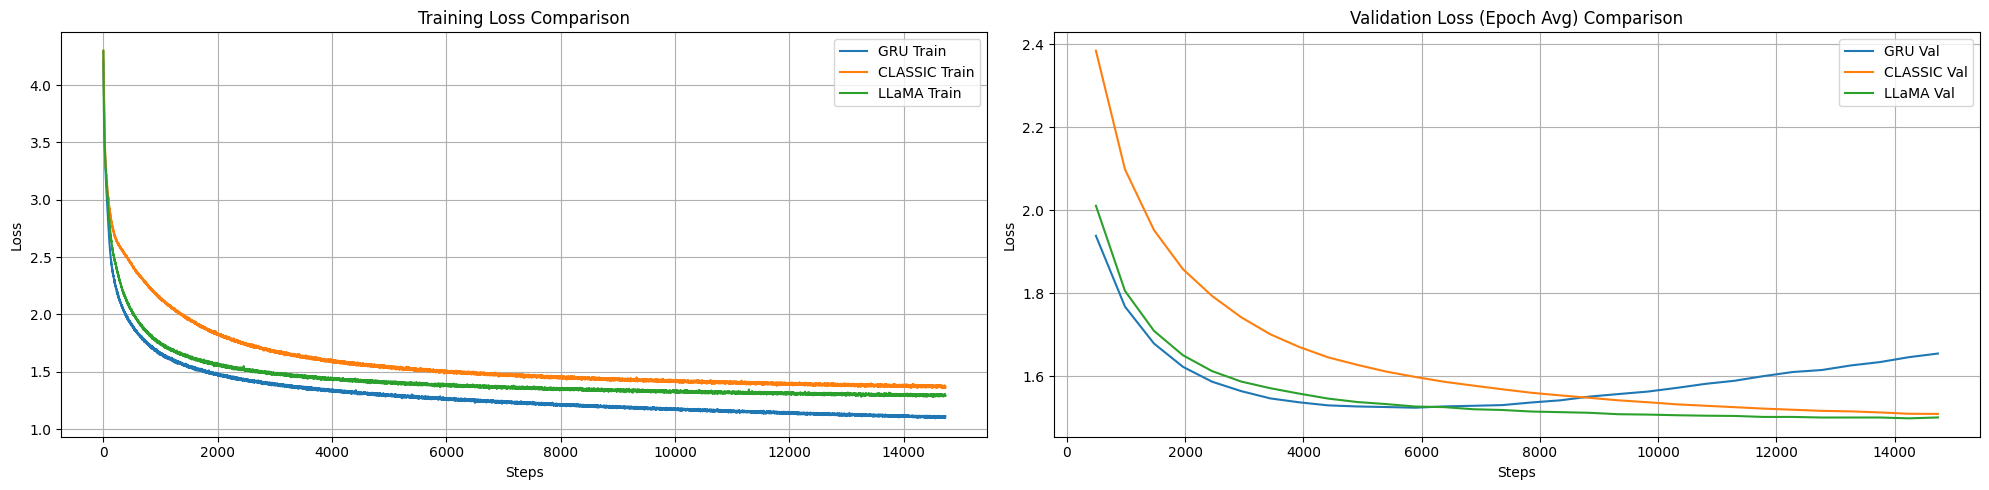

In [37]:
train_and_test("LLaMA", llama, start_text)

## Model 4: Diff Transformer(2024)

In [ ]:
@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    # FFN_DIM = HIDDEN_DIM
    FFN_DIM = 152
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    # x: [B, L, n_kv, d]
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

# FeedForward network.
class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        self.w1 = nn.Linear(dim, ffn_dim, bias=False)
        self.w2 = nn.Linear(ffn_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, ffn_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))


class DiffSelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, depth=0):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep  # typically n_heads // n_kv_heads
        self.head_dim = dim // n_heads  # standard head dimension

        # For diff attention, project Q to 2*n_heads*head_dim,
        # and K, V to 2*n_kv_heads*head_dim.
        self.wq = nn.Linear(dim, 2 * n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, 2 * n_kv_heads * self.head_dim, bias=False)
        # Output projection expects input dim = 2*n_heads*head_dim.
        self.wo = nn.Linear(2 * n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout

        # Lambda parameter as in diff attention paper.
        self.lambda_init = 0.8 - 0.6 * math.exp(-0.3 * depth)
        self.lambda_q1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k1 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_q2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        self.lambda_k2 = nn.Parameter(torch.zeros(self.head_dim, dtype=torch.float32).normal_(mean=0, std=0.1))
        
        # groupnorm
        self.norm = RMSNorm(2*self.head_dim)

    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos # same with start_pos
        
        # Project and reshape: 
        xq = self.wq(x).view(B, trg_len, 2 * self.n_heads_q, self.head_dim)   # [B, L, 2*heads, head_dim]
        xk = self.wk(x).view(B, src_len, 2 * self.n_kv_heads, self.head_dim)  # [B, L, 2*heads_kv, head_dim]
        xv = self.wv(x).view(B, src_len, self.n_kv_heads, 2 * self.head_dim)  # [B, L, heads_kv, 2*head_dim]
        
        # Apply rotary embeddings on queries and keys.
        xq = apply_rotary_emb(xq, device=x.device)
        xk = apply_rotary_emb(xk, device=x.device)
        
        # Grouped Query Attention:
        xq = xq.transpose(1, 2)                         # [B, 2*heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2)  # [B, 2*heads, L, head_dim]
        
        # scaling
        scaling = 1 / math.sqrt(self.head_dim)
        xq *= scaling
        
        attn_weights = torch.matmul(xq, xk.transpose(-1, -2))
        
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
        
        attn_weights = torch.nan_to_num(attn_weights)
        attn_weights += mask
        attn_weights = F.softmax(attn_weights, dim=-1).type_as(attn_weights)
        attn_weights = attn_weights.view(B, self.n_heads_q, 2, trg_len, src_len)
        
        # Combine the two attention scores with lambda.
        lambda_1 = torch.exp(torch.sum(self.lambda_q1 * self.lambda_k1, dim=-1).float()).type_as(xq)
        lambda_2 = torch.exp(torch.sum(self.lambda_q2 * self.lambda_k2, dim=-1).float()).type_as(xq)
        lambda_full = lambda_1 - lambda_2 + self.lambda_init
        
        attn1 = attn_weights[:,:,0]
        attn2 = attn_weights[:,:,1]
        
        attn_weights = attn1 - lambda_full * attn2
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        
        # Compute attention output.
        attn = torch.matmul(attn_weights, xv)
        attn = self.norm(attn)
        attn = attn * (1-self.lambda_init)
        attn = attn.transpose(1, 2).contiguous().view(B, L, -1)
        attn_output = self.wo(attn)
        
        if return_attn:
            # Return four maps:
            # [첫 번째 맵(attn1), 두 번째 맵(attn2), 두 번째 맵에 람다를 곱한 결과, 최종 결과(attn_weights)]
            return attn_output, [attn1, attn2, lambda_full*attn2, attn_weights]
        else:
            return attn_output

class TransformerBlock(nn.Module):
    def __init__(self, args, depth: int = 0):
        super().__init__()
        self.attn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.attention = DiffSelfAttention(
            n_heads=args.NUM_HEADS,
            n_kv_heads=args.NUM_KV_HEADS if args.NUM_KV_HEADS is not None else args.NUM_HEADS,
            n_rep=args.NUM_KV_HEAD_REP,
            dim=args.DIM,
            dropout=args.DROPOUT,
            depth=depth
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos: int, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attn_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attn_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class DiffTransformer(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args, depth=i) for i in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, eps=args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE

    def forward(self, x: torch.Tensor, start_pos: int = 0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, DIM]
        mask = None
        if L > 1:
            mask = torch.triu(torch.full((L, L), float('-inf'), device=self.device), diagonal=1)
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [39]:
PARAMS = ModelArgs()
diff = DiffTransformer(PARAMS).to(device)
diff

DiffTransformer(
  (tok_embeddings): Embedding(65, 128)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attn_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (attention): DiffSelfAttention(
        (wq): Linear(in_features=128, out_features=256, bias=False)
        (wk): Linear(in_features=128, out_features=256, bias=False)
        (wv): Linear(in_features=128, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=128, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=128, out_features=152, bias=False)
        (w2): Linear(in_features=152, out_features=128, bias=False)
        (w3): Linear(in_features=128, out_features=152, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=128, out_features=65, bias=False)
)

In [40]:
from torchinfo import summary

# Describe the model
summary(diff.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
DiffTransformer                          [2048, 64, 65]            --
├─Embedding: 1-1                         [2048, 64, 128]           8,320
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [2048, 64, 128]           --
│    │    └─RMSNorm: 3-1                 [2048, 64, 128]           128
│    │    └─DiffSelfAttention: 3-2       [2048, 64, 128]           131,264
│    │    └─Dropout: 3-3                 [2048, 64, 128]           --
│    │    └─RMSNorm: 3-4                 [2048, 64, 128]           128
│    │    └─FeedForward: 3-5             [2048, 64, 128]           58,368
│    │    └─Dropout: 3-6                 [2048, 64, 128]           --
│    └─TransformerBlock: 2-2             [2048, 64, 128]           --
│    │    └─RMSNorm: 3-7                 [2048, 64, 128]           128
│    │    └─DiffSelfAttention: 3-8       [2048, 64, 128]           131

Epoch 1/30, Train Loss: 2.0075, Val Loss: 2.0495, Epoch Time: 109.24s Average Vram Usage: 91.47MB


Epoch 2/30, Train Loss: 1.7386, Val Loss: 1.8452, Epoch Time: 109.12s Average Vram Usage: 91.47MB


Epoch 3/30, Train Loss: 1.6079, Val Loss: 1.8069, Epoch Time: 110.19s Average Vram Usage: 91.47MB


Epoch 4/30, Train Loss: 1.5486, Val Loss: 1.7969, Epoch Time: 109.86s Average Vram Usage: 91.47MB


Epoch 5/30, Train Loss: 1.5047, Val Loss: 1.7824, Epoch Time: 112.39s Average Vram Usage: 91.47MB


Epoch 6/30, Train Loss: 1.4963, Val Loss: 1.7761, Epoch Time: 58.09s Average Vram Usage: 91.47MB


Epoch 7/30, Train Loss: 1.4653, Val Loss: 1.7741, Epoch Time: 57.52s Average Vram Usage: 91.47MB


Epoch 8/30, Train Loss: 1.4476, Val Loss: 1.7636, Epoch Time: 57.68s Average Vram Usage: 91.47MB


Epoch 9/30, Train Loss: 1.4121, Val Loss: 1.7638, Epoch Time: 57.69s Average Vram Usage: 91.47MB


Epoch 10/30, Train Loss: 1.4346, Val Loss: 1.7544, Epoch Time: 57.66s Average Vram Usage: 91.47MB


Epoch 11/30, Train Loss: 1.3962, Val Loss: 1.7423, Epoch Time: 57.51s Average Vram Usage: 91.47MB


Epoch 12/30, Train Loss: 1.4024, Val Loss: 1.7341, Epoch Time: 57.67s Average Vram Usage: 91.47MB


Epoch 13/30, Train Loss: 1.4135, Val Loss: 1.7331, Epoch Time: 57.76s Average Vram Usage: 91.47MB


Epoch 14/30, Train Loss: 1.3691, Val Loss: 1.7386, Epoch Time: 120.73s Average Vram Usage: 91.47MB


Epoch 15/30, Train Loss: 1.3649, Val Loss: 1.7389, Epoch Time: 122.49s Average Vram Usage: 91.47MB


Epoch 16/30, Train Loss: 1.3576, Val Loss: 1.7412, Epoch Time: 121.83s Average Vram Usage: 91.47MB


Epoch 17/30, Train Loss: 1.3474, Val Loss: 1.7400, Epoch Time: 120.86s Average Vram Usage: 91.47MB


Epoch 18/30, Train Loss: 1.3548, Val Loss: 1.7386, Epoch Time: 121.20s Average Vram Usage: 91.47MB


Epoch 19/30, Train Loss: 1.3351, Val Loss: 1.7354, Epoch Time: 121.50s Average Vram Usage: 91.47MB


Epoch 20/30, Train Loss: 1.3266, Val Loss: 1.7446, Epoch Time: 129.91s Average Vram Usage: 91.47MB


Epoch 21/30, Train Loss: 1.3411, Val Loss: 1.7322, Epoch Time: 138.96s Average Vram Usage: 91.47MB


Epoch 22/30, Train Loss: 1.3301, Val Loss: 1.7430, Epoch Time: 137.50s Average Vram Usage: 91.47MB


Epoch 23/30, Train Loss: 1.3408, Val Loss: 1.7416, Epoch Time: 144.67s Average Vram Usage: 91.47MB


Epoch 24/30, Train Loss: 1.3287, Val Loss: 1.7383, Epoch Time: 144.96s Average Vram Usage: 91.47MB


Epoch 25/30, Train Loss: 1.3106, Val Loss: 1.7337, Epoch Time: 144.27s Average Vram Usage: 91.47MB


Epoch 26/30, Train Loss: 1.3056, Val Loss: 1.7453, Epoch Time: 142.05s Average Vram Usage: 91.47MB


Epoch 27/30, Train Loss: 1.3167, Val Loss: 1.7371, Epoch Time: 144.68s Average Vram Usage: 91.47MB


Epoch 28/30, Train Loss: 1.3258, Val Loss: 1.7302, Epoch Time: 144.81s Average Vram Usage: 91.47MB


Epoch 29/30, Train Loss: 1.3041, Val Loss: 1.7383, Epoch Time: 141.24s Average Vram Usage: 91.47MB


Epoch 30/30, Train Loss: 1.3247, Val Loss: 1.7352, Epoch Time: 144.61s Average Vram Usage: 91.47MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, Sir, weeping the night;
Alas, to the morning your good fine to speak;
Pirsue your grace! This prayers with us.
That all me into my son: all believes in these prithee:
But you that seem the old at the heavest of yourselves.

KING RICHARD III:
Why have provost?

CLARENCE:
Unless you flattering made for you.
To the Ansel of your fent axe,
Of thy own soft to convenient pays,
Thy slanders he makes successed in their regiment
Enformoning, whom above you fall'n office,
And not the Measure carpetite;
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro
--------------------------------------------------


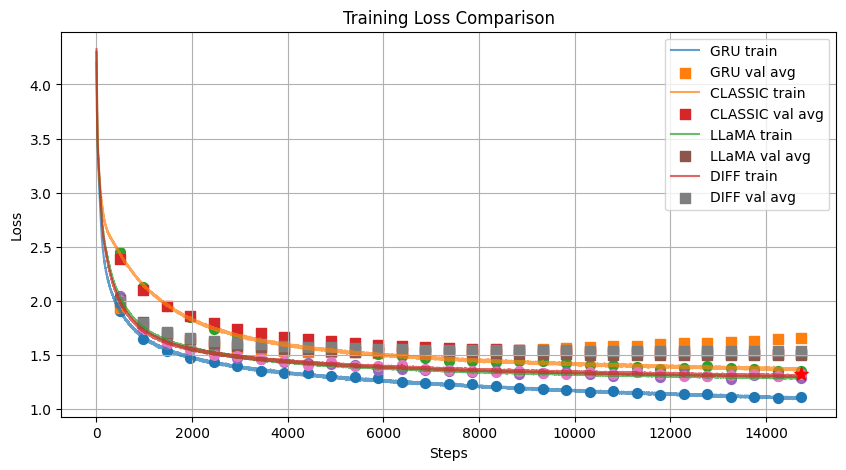

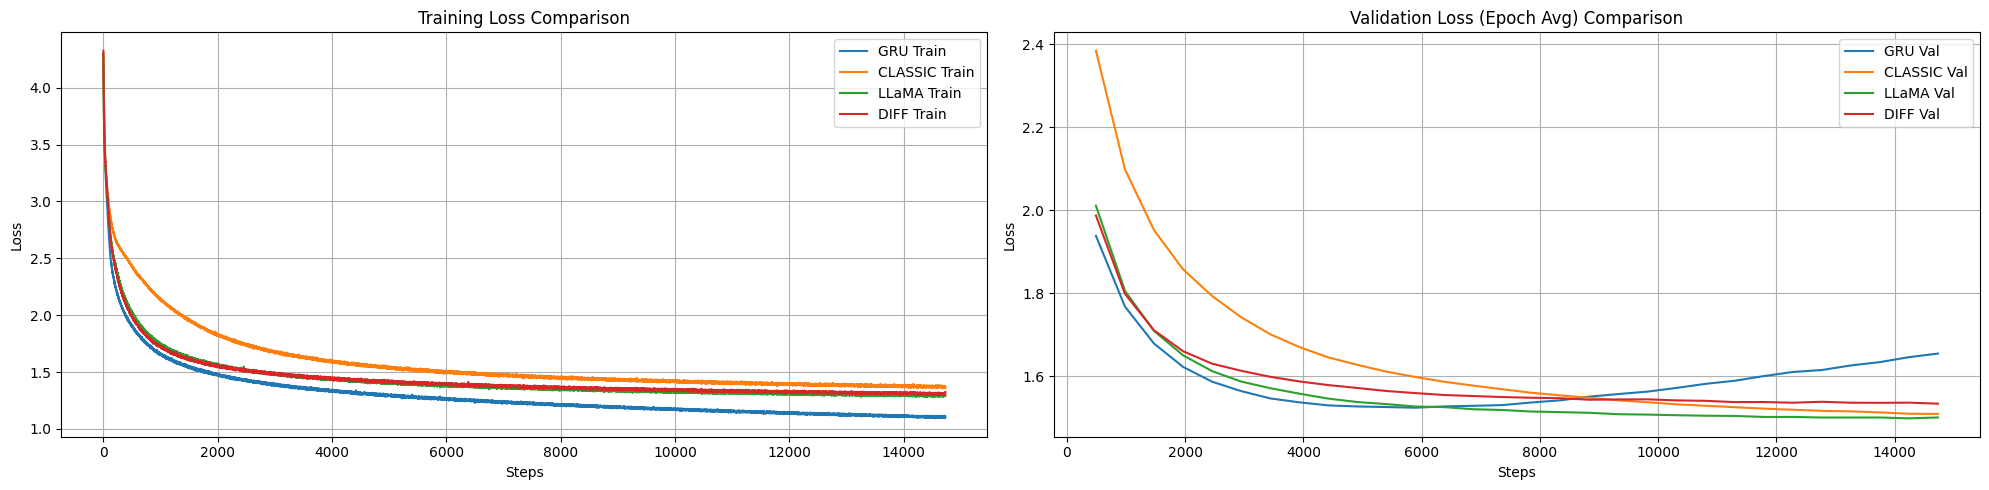

In [41]:
train_and_test("DIFF", diff, start_text)

## Compare Attention Map

In [ ]:
import matplotlib.pyplot as plt
import torch

def compare_attention_maps(models_dict, dataloader, start_pos=0, layer=0, head=0):

    # Fetch a single batch from the dataloader.
    x, _ = next(iter(dataloader))
    device = 'cuda:0'
    x = x.to(device)
    
    attn_results = {}
    
    # For each model, perform a forward pass to obtain attention maps.
    for name, model in models_dict.items():
        model = model.to(device)
        model.eval()
        with torch.inference_mode():
            # For classic model, assume its forward signature differs (doesn't need start_pos)
            if name == 'classic':
                _, attn_maps = model.forward(x, return_attn=True)
                attn = attn_maps[layer][head] 
                attn_results[name] = attn.detach().cpu().numpy()
            elif name == 'llama':
                _, attn_maps = model.forward(x, start_pos=start_pos, return_attn=True)
                attn = attn_maps[layer][0, head] 
                attn_results[name] = attn.detach().cpu().numpy()
            elif name == 'diff':
                _, attn_maps = model.forward(x, start_pos=start_pos, return_attn=True)
                attns = attn_maps[layer]         
                names = ['attn1', 'attn2', 'λ*attn2', 'attn1-λ*attn2']
                for name, attn in zip(names, attns):
                    attn_results[name] = attn[0, head].detach().cpu().numpy()

    n_models = len(attn_results)
    fig, axs = plt.subplots(1, n_models, figsize=(n_models * 4, 4))
    if n_models == 1:
        axs = [axs]

    for ax, (name, attn) in zip(axs, attn_results.items()):
        if 'attn1-λ*attn2' in name:
            im = ax.imshow(attn, interpolation='nearest', cmap='seismic', vmin=-1, vmax=1)
        else:
            im = ax.imshow(attn, interpolation='nearest', cmap='Reds', vmin=np.min(attn), vmax=np.max(attn))
        ax.set_title(f"{name.upper()} \nLayer {layer+1}, Head {head+1}")
        ax.set_xlabel("Key Token Position")
        ax.set_ylabel("Query Token Position")
        fig.colorbar(im, ax=ax)
        
    plt.tight_layout()
    plt.show()

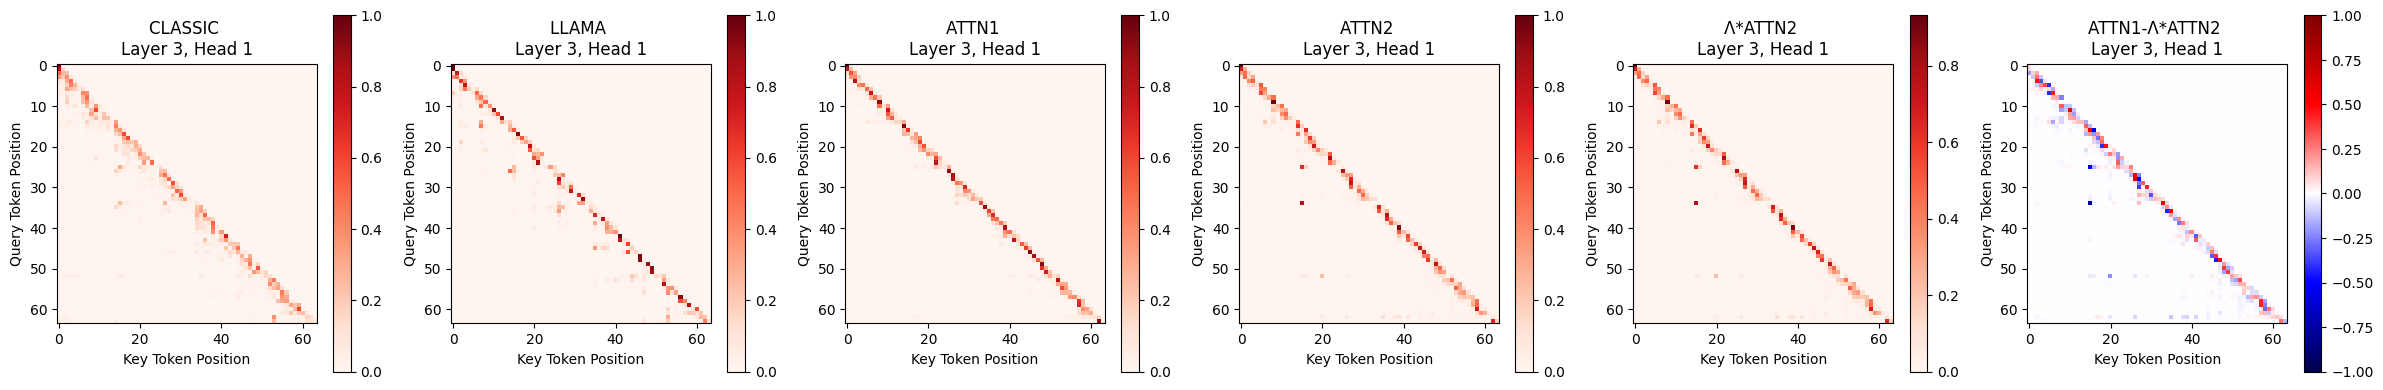

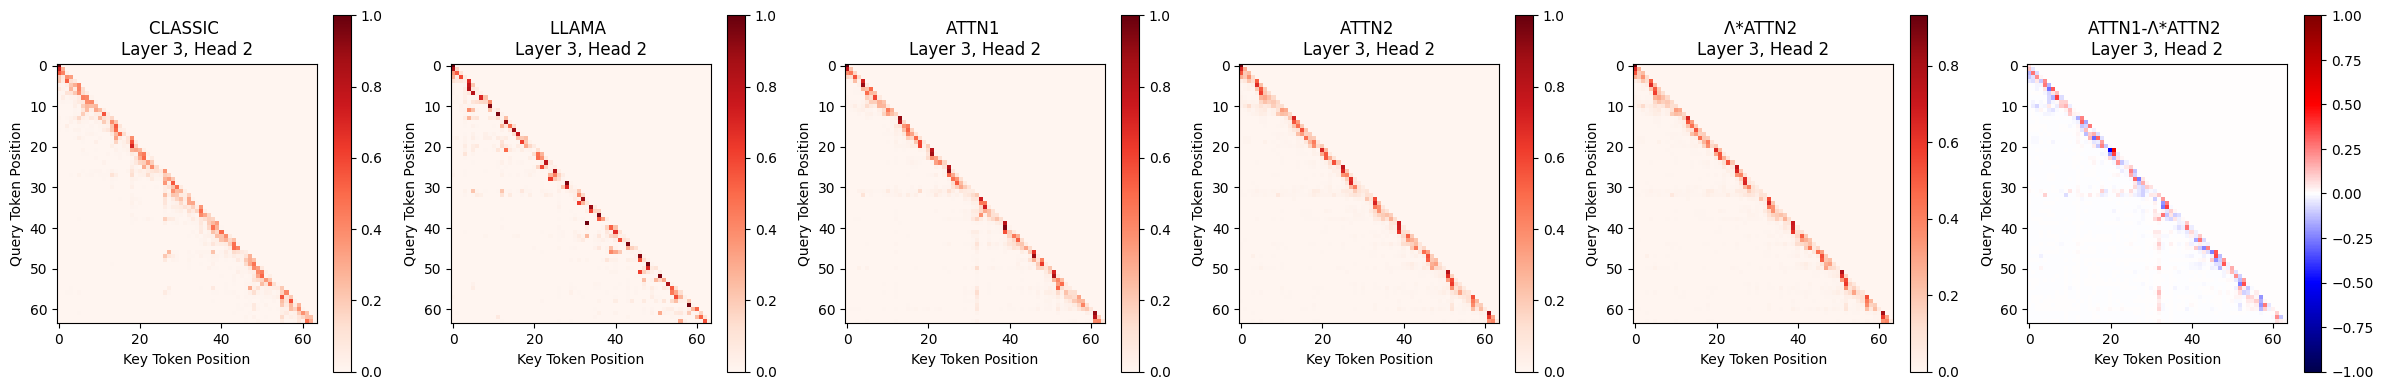

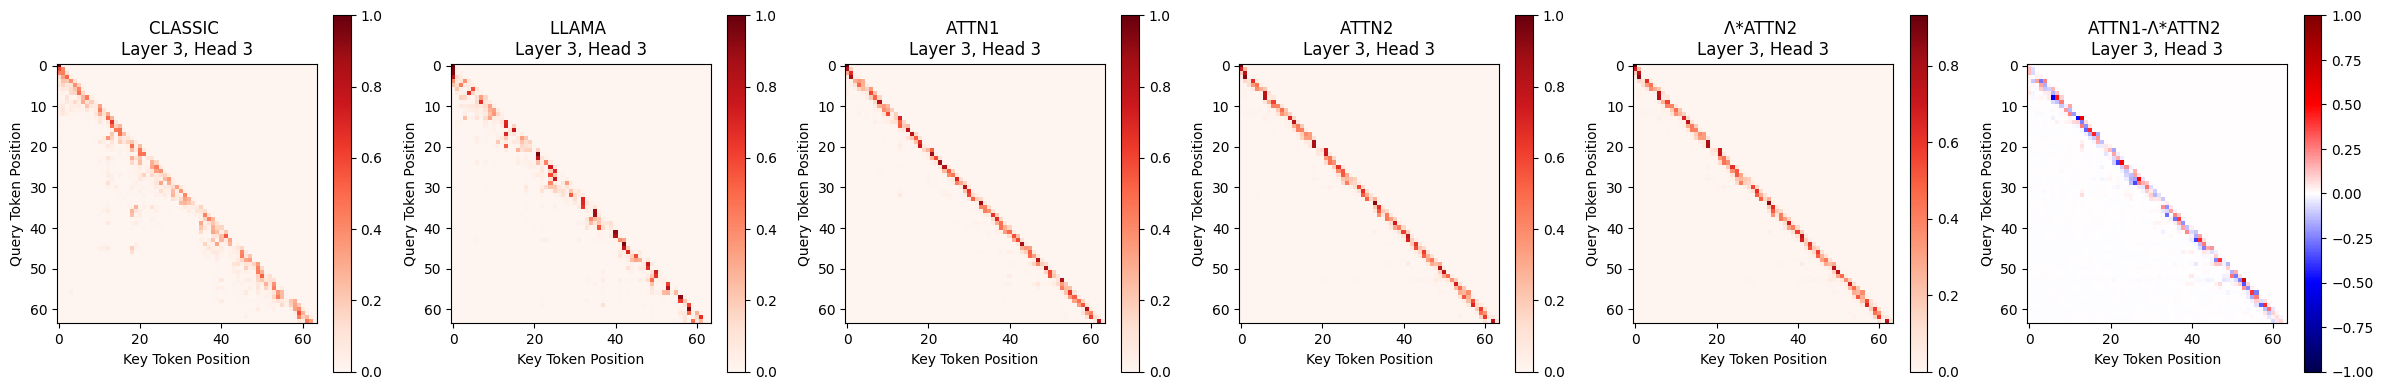

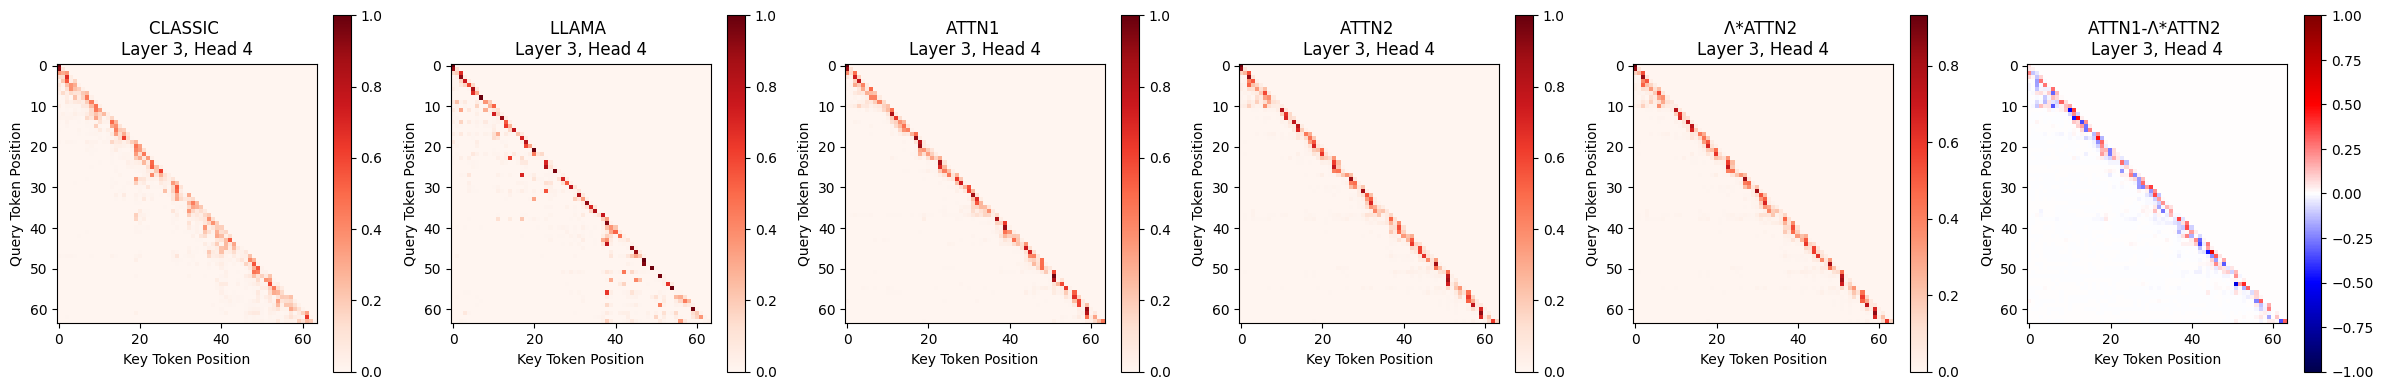

In [51]:
models = {
    "classic": classic,
    "llama": llama,
    "diff": diff,
}

for i in range(4):
    compare_attention_maps(models, train_loader, start_pos=0, layer=2, head=i)

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def compare_attention_maps(models_dict, dataloader, start_pos=0, layer=0, head=0):

    # 단일 배치를 가져옵니다.
    x, _ = next(iter(dataloader))
    device = 'cuda:0'
    x = x.to(device)
    
    attn_results = {}
    
    # 각 모델의 attention map을 계산합니다.
    for name, model in models_dict.items():
        model = model.to(device)
        model.eval()
        with torch.inference_mode():
            if name == 'classic':
                _, attn_maps = model.forward(x, return_attn=True)
                attn = attn_maps[layer][head] 
                attn_results[name] = attn.detach().cpu().numpy()
            elif name == 'llama':
                _, attn_maps = model.forward(x, start_pos=start_pos, return_attn=True)
                attn = attn_maps[layer][0, head] 
                attn_results[name] = attn.detach().cpu().numpy()
            elif name == 'diff':
                _, attn_maps = model.forward(x, start_pos=start_pos, return_attn=True)
                attns = attn_maps[layer]         
                names = ['attn1', 'attn2', 'λ*attn2', 'attn1-λ*attn2']
                for n, attn in zip(names, attns):
                    attn_results[n] = attn[0, head].detach().cpu().numpy()

    n_models = len(attn_results)
    # 그래프를 한 줄에 한 개씩 배치하도록 (n_models 행, 1 열) 설정
    fig, axs = plt.subplots(n_models, 1, figsize=(12, n_models * 12))
    if n_models == 1:
        axs = [axs]

    for ax, (name, attn) in zip(axs, attn_results.items()):
        if 'attn1-λ*attn2' in name:
            im = ax.imshow(attn, interpolation='nearest', cmap='seismic', vmin=-1, vmax=1)
        else:
            im = ax.imshow(attn, interpolation='nearest', cmap='Reds', vmin=np.min(attn), vmax=np.max(attn))
        ax.set_title(f"{name.upper()} \nLayer {layer+1}, Head {head+1}")
        ax.set_xlabel("Key Token Position")
        ax.set_ylabel("Query Token Position")
        fig.colorbar(im, ax=ax)
        
        # 각 셀에 실제 수치 값을 표시 (0인 값은 표시하지 않음)
        rows, cols = attn.shape
        for i in range(rows):
            for j in range(cols):
                if -0.01 < attn[i, j] < 0.01:
                    continue
                ax.text(j, i, f"{attn[i, j]*100:.0f}", ha="center", va="center", fontsize=8, color="black")
        
    plt.tight_layout()
    plt.show()

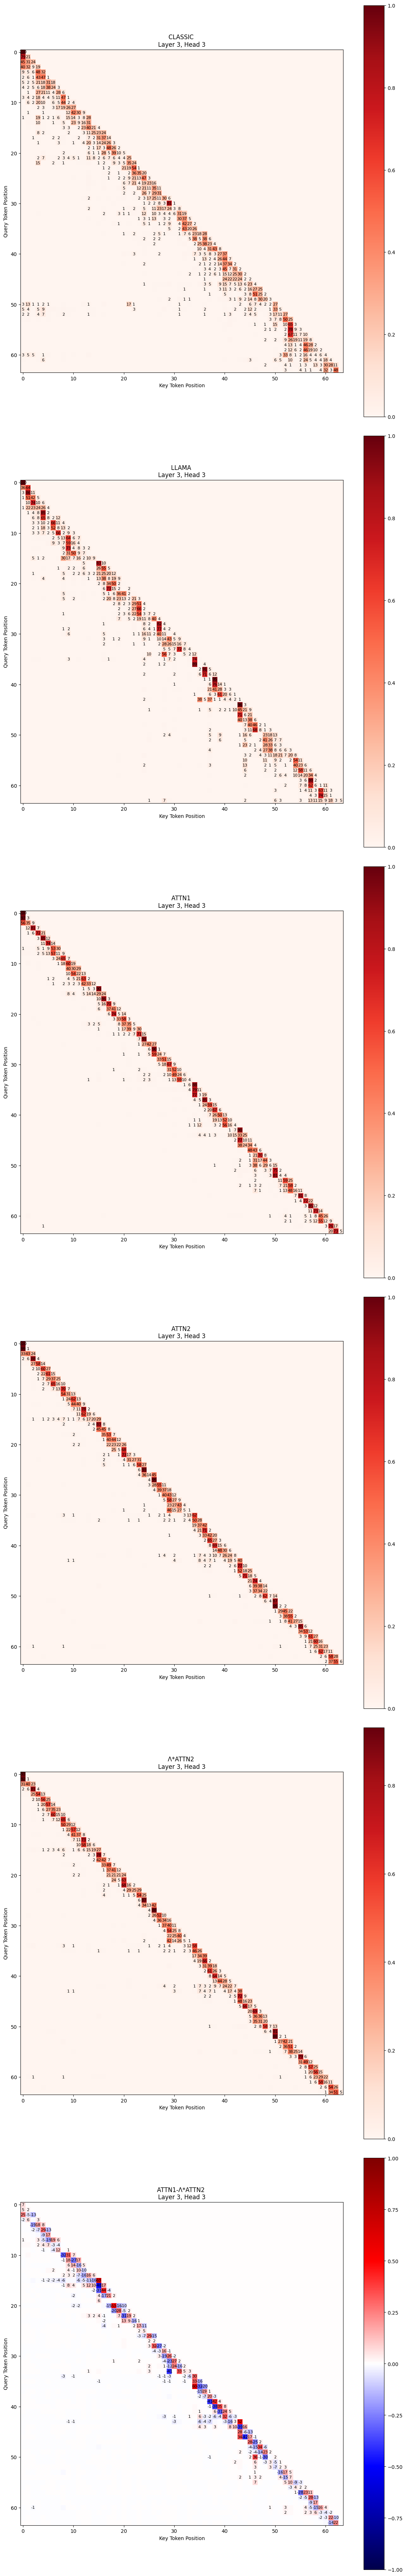

In [90]:
models = {
    "classic": classic,
    "llama": llama,
    "diff": diff,
}

compare_attention_maps(models, train_loader, start_pos=0, layer=2, head=2)